In [37]:
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [38]:
# ================================
# CONFIG
# ================================
DATA_PATH = r"D:\GWQM\groundwater_cleaned.csv"
OUT_DIR = r"D:\GWQM\models"
os.makedirs(OUT_DIR, exist_ok=True)


RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print("Using device:", DEVICE)

Using device: cpu


In [20]:
# ================================
# 1) LOAD & BASIC CLEANING
# ================================
print("\n[1] Loading dataset...")

df = pd.read_csv(DATA_PATH)

# Standardize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Identify numeric and location columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
location_cols = [c for c in ["state", "district"] if c in df.columns]

# Keep only numeric features for unsupervised learning
df_num = df[numeric_cols].copy()

# Convert to numeric & handle missing values
for c in numeric_cols:
    df_num[c] = pd.to_numeric(df_num[c], errors="coerce")
    df_num[c].fillna(df_num[c].median(), inplace=True)

# Remove duplicate rows
df_num.drop_duplicates(inplace=True)

print("Numeric features:", numeric_cols)
print("Shape after cleaning:", df_num.shape)



[1] Loading dataset...
Numeric features: ['s._no.', 'latitude', 'longitude', 'year', 'ph', 'ec_in_μs/cm', 'co3', 'hco3', 'cl', 'so4', 'no3', 'po4', 'th', 'ca', 'mg', 'na', 'k', 'f', 'tds', 'sio2', 'ec_tds_ratio', 'hardness_class', 'ph_safe', 'no3_safe', 'f_safe']
Shape after cleaning: (13549, 25)



[2] Handling outliers (IQR)...


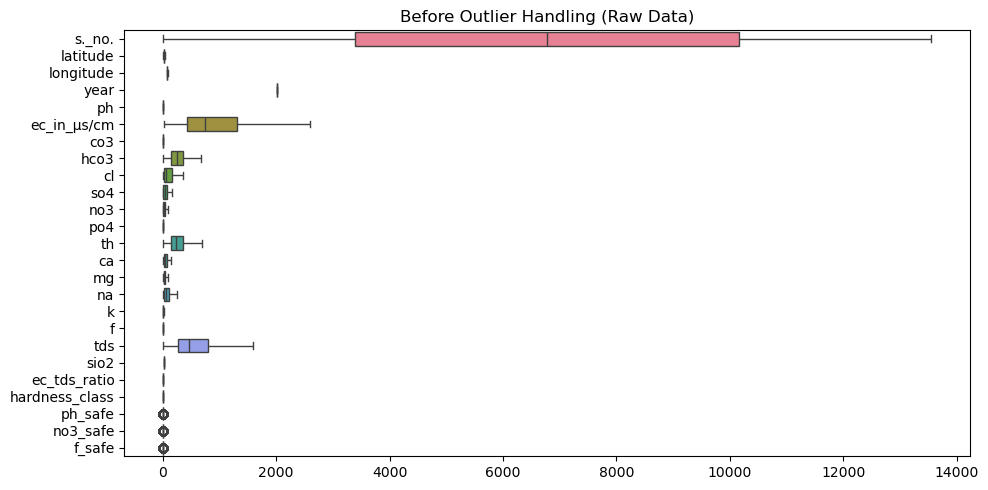

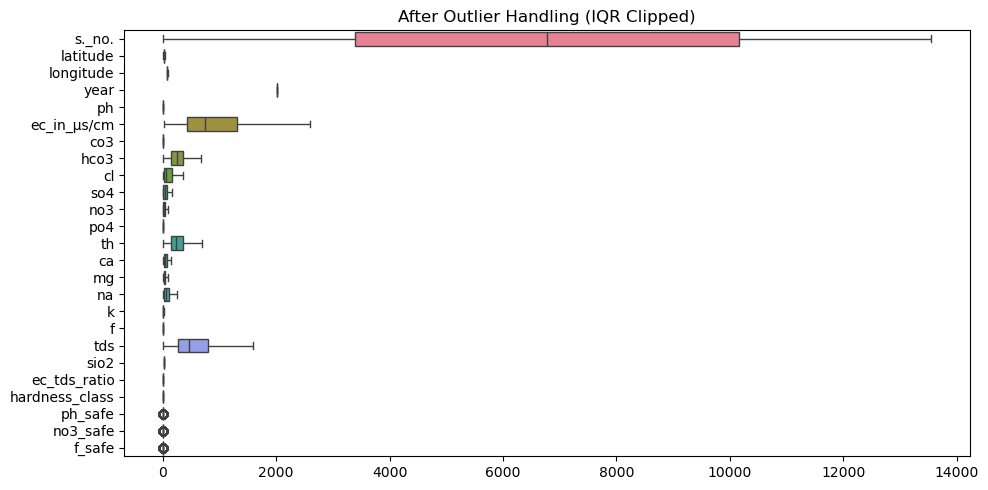

In [39]:
# ================================
# OUTLIER VISUALIZATION + IQR CLIPPING
# ================================
print("\n[2] Handling outliers (IQR)...")

# -------- BEFORE outlier handling --------
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_num, orient="h")
plt.title("Before Outlier Handling (Raw Data)")
plt.tight_layout()
plt.show()


# -------- IQR clipping function --------
def iqr_clip(df, cols):
    out = df.copy()
    for col in cols:
        q1 = out[col].quantile(0.25)
        q3 = out[col].quantile(0.75)
        iqr = q3 - q1

        # Skip constant columns
        if iqr == 0:
            continue

        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        out[col] = out[col].clip(lower, upper)

    return out


# Apply IQR clipping
df_num = iqr_clip(df_num, numeric_cols)


# -------- AFTER outlier handling --------
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_num, orient="h")
plt.title("After Outlier Handling (IQR Clipped)")
plt.tight_layout()
plt.show()


In [40]:
# ================================
# 3) SCALING (UNSUPERVISED SETUP)
# ================================
print("\n[3] Scaling features (unsupervised)...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num.values)

joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))

print("Scaled data shape:", X_scaled.shape)



[3] Scaling features (unsupervised)...
Scaled data shape: (13549, 25)



[4] PCA dimensionality reduction...


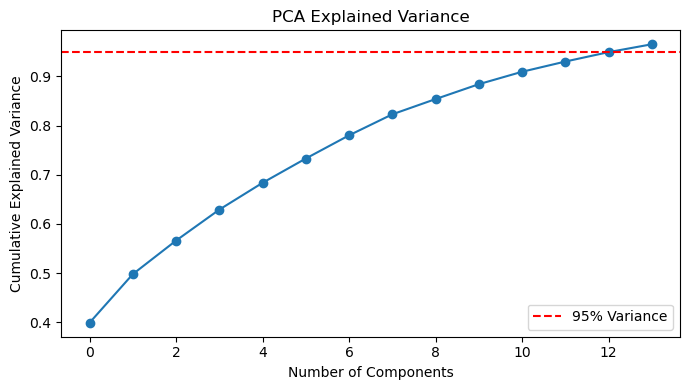

PCA components selected: 14


In [42]:
# ================================
# 4) PCA (LATENT SPACE) + VARIANCE VISUALIZATION
# ================================
print("\n[4] PCA dimensionality reduction...")

pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# Save PCA model
joblib.dump(pca, os.path.join(OUT_DIR, "pca.joblib"))

# ----------------
# Explained variance plot
# ----------------
plt.figure(figsize=(7, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.axhline(0.95, color="r", linestyle="--", label="95% Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.legend()
plt.tight_layout()
plt.show()

print("PCA components selected:", X_pca.shape[1])


In [44]:
# ================================
# 5) AUTOENCODER (ANOMALY CORE)
# ================================
print("\n[5] Training Autoencoder...")

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        xrec = self.decoder(z)
        return xrec, z


def train_autoencoder(X, epochs=50, batch_size=32):
    model = Autoencoder(X.shape[1]).to(DEVICE)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-3,
        weight_decay=1e-4  # prevents overfitting
    )

    loss_fn = nn.MSELoss()

    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()

    for ep in range(epochs):
        epoch_loss = 0.0

        for (xb,) in dataloader:
            xb = xb.to(DEVICE)

            xrec, _ = model(xb)
            loss = loss_fn(xrec, xb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if (ep + 1) % 10 == 0:
            print(
                f"AE Epoch {ep+1}/{epochs} | "
                f"Loss = {epoch_loss / len(dataloader):.6f}"
            )

    return model


# Train on full PCA data (correct for unsupervised monitoring)
ae = train_autoencoder(X_pca)

# Save model
torch.save(ae.state_dict(), os.path.join(OUT_DIR, "autoencoder.pt"))



[5] Training Autoencoder...
AE Epoch 10/50 | Loss = 0.144391
AE Epoch 20/50 | Loss = 0.128698
AE Epoch 30/50 | Loss = 0.128533
AE Epoch 40/50 | Loss = 0.122946
AE Epoch 50/50 | Loss = 0.118645


In [45]:
# ================================
# 6) RECONSTRUCTION ERROR + LATENT DRIFT (BASELINE)
# ================================
print("\n[6] Computing reconstruction error & latent drift...")

ae.eval()

with torch.no_grad():
    Xt = torch.tensor(X_pca, dtype=torch.float32).to(DEVICE)
    Xrec, Z = ae(Xt)

Xrec = Xrec.cpu().numpy()
Z = Z.cpu().numpy()

# ----------------
# Reconstruction error (baseline anomaly score)
# ----------------
recon_error = np.mean((X_pca - Xrec) ** 2, axis=1)

# ----------------
# Latent baseline statistics
# ----------------
latent_mean = Z.mean(axis=0)
latent_std = Z.std(axis=0)

print("Reconstruction error stats:")
print(f" Mean       : {recon_error.mean():.6f}")
print(f" 95th perc. : {np.percentile(recon_error, 95):.6f}")
print(f" Max        : {recon_error.max():.6f}")



[6] Computing reconstruction error & latent drift...
Reconstruction error stats:
 Mean       : 0.075377
 95th perc. : 0.218732
 Max        : 1.199033


In [46]:
# ================================
# 7) UNSUPERVISED MODEL COMPARISON (LATENT SPACE)
# ================================
print("\n[7] Comparing unsupervised models on latent space...")

results = []

models = {
    "dbscan": DBSCAN(eps=0.5, min_samples=10),
    "agglomerative": AgglomerativeClustering(n_clusters=4)
}

for name, model in models.items():
    labels = model.fit_predict(Z)

    # Handle noise for DBSCAN
    if -1 in labels:
        mask = labels != -1
        Z_eval = Z[mask]
        labels_eval = labels[mask]
    else:
        Z_eval = Z
        labels_eval = labels

    # Need at least 2 clusters
    if len(set(labels_eval)) < 2:
        print(f"{name}: skipped (less than 2 clusters)")
        continue

    sil = silhouette_score(Z_eval, labels_eval)
    dbi = davies_bouldin_score(Z_eval, labels_eval)
    chi = calinski_harabasz_score(Z_eval, labels_eval)

    results.append({
        "model": name,
        "silhouette": sil,
        "db": dbi,
        "ch": chi
    })

    print(
        f"{name}: silhouette={sil:.4f}, "
        f"DB={dbi:.4f}, "
        f"CH={chi:.2f}"
    )

# Convert to DataFrame
results_df = pd.DataFrame(results)

# ----------------
# Select best model (scientific ranking)
# ----------------
results_df["rank"] = (
    results_df["silhouette"].rank(ascending=False) +
    results_df["db"].rank(ascending=True) +
    results_df["ch"].rank(ascending=False)
)

best_name = results_df.sort_values("rank").iloc[0]["model"]

print("\n✅ Selected clustering model:", best_name)

best_cluster_model = models[best_name]
cluster_labels = best_cluster_model.fit_predict(Z)



[7] Comparing unsupervised models on latent space...
dbscan: silhouette=0.5750, DB=0.5142, CH=984.63
agglomerative: silhouette=0.0841, DB=2.3247, CH=1393.49

✅ Selected clustering model: dbscan


In [30]:
# ================================
# 8) OPTIONAL RANDOM FOREST (FAST INFERENCE)
# ================================
print("\n[8] Training RandomForest (cluster emulator)...")
mask = cluster_labels != -1
X_rf = X_pca[mask]
y_rf = cluster_labels[mask]


rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_rf, y_rf)
joblib.dump(rf, os.path.join(OUT_DIR, "rf_cluster_emulator.joblib"))


print("RF trained. Classes:", np.unique(y_rf))


[8] Training RandomForest (cluster emulator)...
RF trained. Classes: [0 1 2 3 4 5]


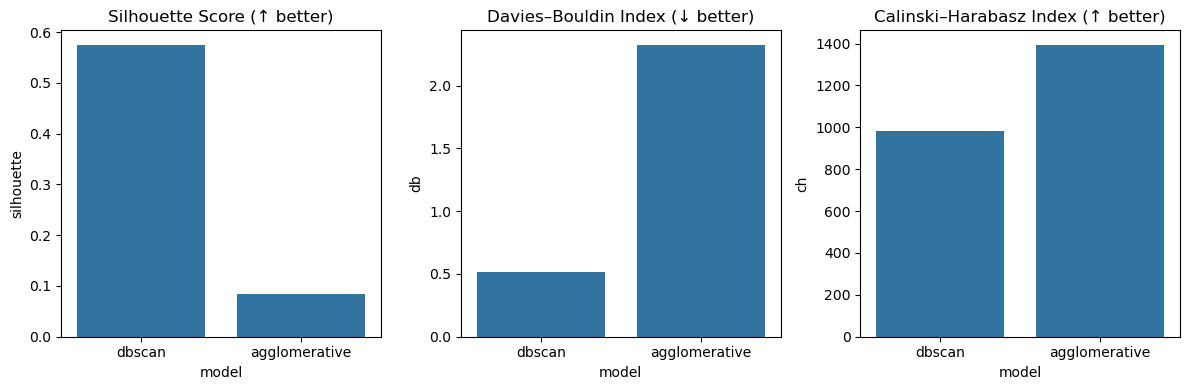

In [47]:
# ----------------
# Score comparison visualization
# ----------------
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.barplot(data=results_df, x="model", y="silhouette", ax=ax[0])
ax[0].set_title("Silhouette Score (↑ better)")

sns.barplot(data=results_df, x="model", y="db", ax=ax[1])
ax[1].set_title("Davies–Bouldin Index (↓ better)")

sns.barplot(data=results_df, x="model", y="ch", ax=ax[2])
ax[2].set_title("Calinski–Harabasz Index (↑ better)")

plt.tight_layout()
plt.show()


In [48]:
# ================================
# 8) OPTIONAL RANDOM FOREST (CLUSTER EMULATOR)
# ================================
print("\n[8] Training RandomForest (cluster emulator)...")

# Use only non-noise samples
mask = cluster_labels != -1
X_rf = X_pca[mask]
y_rf = cluster_labels[mask]

# Random Forest as fast cluster approximator
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,              # prevents overfitting
    min_samples_leaf=5,        # stability
    class_weight="balanced",   # cluster imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_rf, y_rf)

# Save model
joblib.dump(rf, os.path.join(OUT_DIR, "rf_cluster_emulator.joblib"))

print("RF trained. Cluster classes:", np.unique(y_rf))



[8] Training RandomForest (cluster emulator)...
RF trained. Cluster classes: [ 0  1  2  3  4  5  6  7  8  9 10]


In [49]:
# ================================
# 9) WQI (FOR INTERPRETABLE QUALITY)
# ================================
print("\n[9] Computing WQI...")

# Min–Max normalization
X_min = df_num.min()
X_max = df_num.max()

X_norm = (df_num - X_min) / (X_max - X_min + 1e-9)

# Simple Water Quality Index (mean of normalized parameters)
wqi = X_norm.mean(axis=1)

# ----------------
# WQI categorization
# ----------------
def wqi_category(v):
    if v < 0.5:
        return "Poor"
    elif v < 0.7:
        return "Moderate"
    else:
        return "Good"

wqi_cat = wqi.apply(wqi_category)

print("WQI category distribution:")
print(wqi_cat.value_counts())



[9] Computing WQI...
WQI category distribution:
Poor        11066
Moderate     2482
Good            1
Name: count, dtype: int64


In [50]:
# ================================
# 10) MODE 1 — DISTRICT-BASED ASSESSMENT
# ================================
print("\n[10] District-based assessment demo...")

def district_assessment(state=None, district=None):
    data = df.copy()

    # Filter by state if provided
    if state and "state" in data.columns:
        data = data[data["state"] == state]

    # Filter by district if provided
    if district and "district" in data.columns:
        data = data[data["district"] == district]

    # If no data after filtering
    if data.empty:
        return {
            "avg_wqi": None,
            "category": "No data available"
        }

    # Average numeric parameters
    avg_params = data[numeric_cols].mean()

    # Compute average WQI
    avg_wqi = ((avg_params - X_min) / (X_max - X_min + 1e-9)).mean()

    return {
        "avg_wqi": float(avg_wqi),
        "category": wqi_category(avg_wqi)
    }

# Example usage
print("District result:", district_assessment())



[10] District-based assessment demo...
District result: {'avg_wqi': 0.40534311618924124, 'category': 'Poor'}


In [36]:
# ================================
# 11) MODE 2 — SAMPLE-BASED MONITORING
# ================================
print("\n[11] Sample-based monitoring demo...")

def monitor_sample(sample_dict):
    # Build input vector in correct feature order
    x = np.array([sample_dict[c] for c in numeric_cols], dtype=np.float32).reshape(1, -1)

    # Preprocessing
    xs = scaler.transform(x)
    xp = pca.transform(xs)

    # Autoencoder inference
    ae.eval()
    with torch.no_grad():
        xt = torch.tensor(xp, dtype=torch.float32).to(DEVICE)
        xrec, z = ae(xt)

    # Reconstruction error
    xrec_np = xrec.cpu().numpy()
    rec_err = np.mean((xp - xrec_np) ** 2)

    # Latent drift (distance from baseline mean)
    z_np = z.cpu().numpy()
    drift = np.linalg.norm(z_np - latent_mean)

    # Decision logic
    status = "Normal"
    if rec_err > np.percentile(recon_error, 95):
        status = "Anomalous / Contaminated"

    return {
        "reconstruction_error": float(rec_err),
        "latent_drift": float(drift),
        "status": status
    }


# ----------------
# Test with median (baseline) sample
# ----------------
sample = {c: float(df_num[c].median()) for c in numeric_cols}
print("Sample monitoring result:", monitor_sample(sample))

print("\nPipeline finished successfully.")



[11] Sample-based monitoring demo...
Sample monitoring result: {'reconstruction_error': 0.03243216057690349, 'latent_drift': 0.9055861830711365, 'status': 'Normal'}

Pipeline finished successfully.



[12] Generating visualizations...


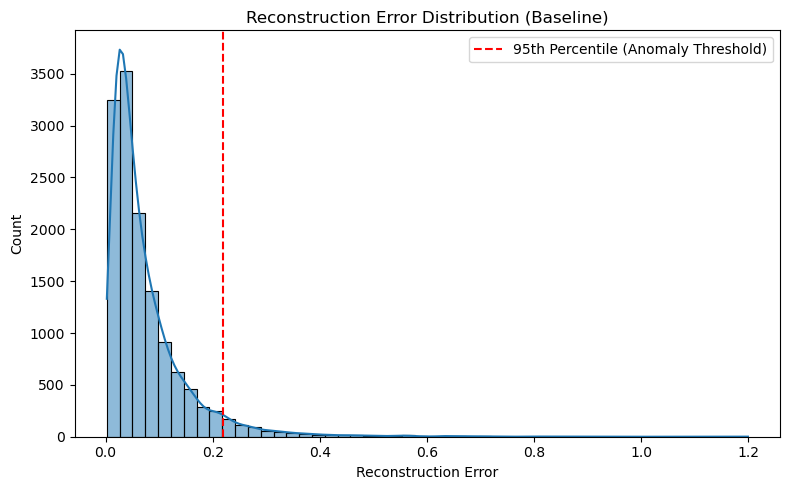

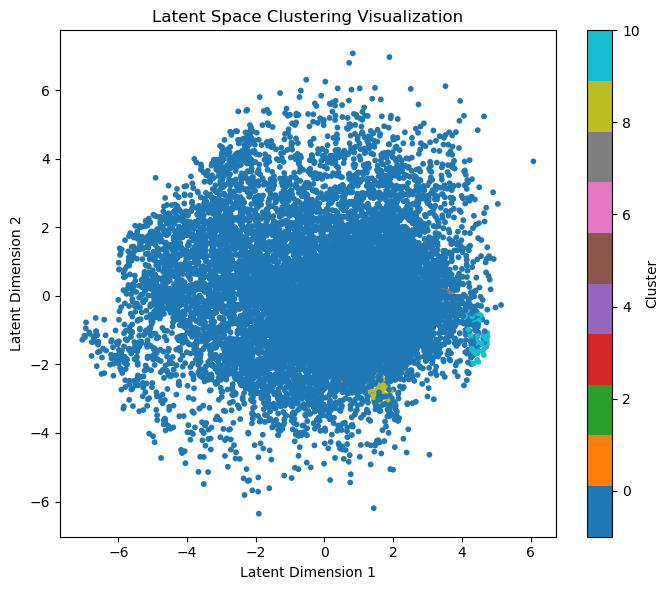

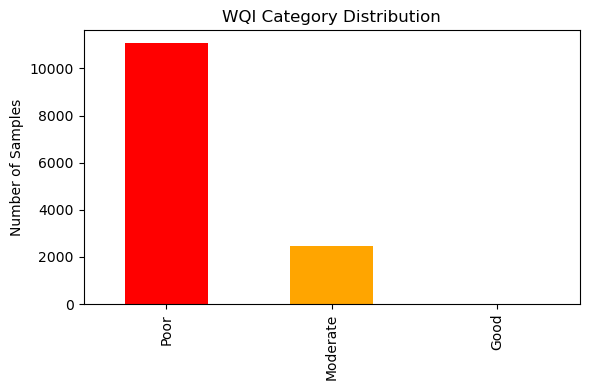

Visualizations generated successfully.

Pipeline finished successfully.


In [52]:
# ================================
# 12) VISUALIZATIONS & DIAGNOSTICS
# ================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n[12] Generating visualizations...")

# -------------------------------
# 12.1 Reconstruction Error Distribution
# -------------------------------
plt.figure(figsize=(8, 5))
sns.histplot(recon_error, bins=50, kde=True)
plt.axvline(
    np.percentile(recon_error, 95),
    color="r",
    linestyle="--",
    label="95th Percentile (Anomaly Threshold)"
)
plt.xlabel("Reconstruction Error")
plt.title("Reconstruction Error Distribution (Baseline)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 12.2 Latent Space Visualization (2D PCA)
# -------------------------------
from sklearn.decomposition import PCA as PCA2

latent_2d = PCA2(n_components=2, random_state=42).fit_transform(Z)

plt.figure(figsize=(7, 6))
plt.scatter(
    latent_2d[:, 0],
    latent_2d[:, 1],
    c=cluster_labels,
    cmap="tab10",
    s=10
)
plt.colorbar(label="Cluster")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Clustering Visualization")
plt.tight_layout()
plt.show()

# -------------------------------
# 12.3 WQI Category Distribution
# -------------------------------
plt.figure(figsize=(6, 4))
wqi_cat.value_counts().plot(
    kind="bar",
    color=["red", "orange", "green"]
)
plt.ylabel("Number of Samples")
plt.title("WQI Category Distribution")
plt.tight_layout()
plt.show()

print("Visualizations generated successfully.")
print("\nPipeline finished successfully.")
